<H3>Using craigslist for rental details to cluster with neighborhood venus</H3>

   The core idea of the project is to cluster each rental place with related to the venuses nearby to that particular rental place. By clustering each rental place based on the venuses, user can make a easy decision based on venuses in a particular cluster when selecting a rental place.
   
   <H6> We will be obtaning the rental listing from Craigslist rental website using the CraigslistHousing and The list will only contain apartment which are available for renting. We will obtain the near by venus of all the rental place using FourSquare API to plot the map with rental place and nearby venuses.</H6>

In [1]:
#required imports for the project!!
import numpy as np 
import pandas as pd

# library to scrap the web page 
from bs4 import BeautifulSoup

# library to handle JSON files
import json

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


<H3>Loading Data and Data Cleaning</H3>

In [2]:
#using craigslist to get rental data of San Francisco up to 50 listings!!
from craigslist import CraigslistHousing
cl = CraigslistHousing(site='sfbay', area='sfc', category='apa')
results = cl.get_results(sort_by='newest', geotagged=True, limit=100)

In [4]:
#creating data frame of the rental data!!
rental_data = pd.DataFrame(results)
rental_data['geotag'] = rental_data['geotag'].map(lambda x: str(x).lstrip('(').rstrip(')'))
rental_data['Latitude'], rental_data['Longitude'] = rental_data['geotag'].str.split(',', 1).str
rental_data['Latitude'] = rental_data['Latitude'].astype(float)
rental_data['Longitude'] = rental_data['Longitude'].astype(float)
rental_data.drop(['geotag','last_updated','has_image','datetime','repost_of'],1,inplace=True)
rental_data.drop_duplicates(subset='id',keep='first',inplace=True)
rental_data

,id,name,url,price,where,Latitude,Longitude
0,7032990766,"Prime Location, Amenities, Pet Friendly, Wooft...",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$4190,SOMA / south beach,37.786588,-122.401596
1,7047709792,"1 BR in 3BR, 2 BA Apartment",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$1850,lower pac hts,37.785600,-122.435800
2,7040514449,Remodeled 1 Bedroom 1 Bath- Furnished- laundr...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$1800,portola district,37.719000,-122.409600
3,7047709931,Spectacular Panoramic City Skyline&Bay views ...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$5395,castro / upper market,37.757340,-122.445891
4,7047709758,Spectacular Panoramic City Skyline&Bay views ...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$4895,castro / upper market,37.757340,-122.445891
...,...,...,...,...,...,...,...
95,7044873936,Beautiful HUGE Two Bedroom Apartment close to ...,https://sfbay.craigslist.org/sfc/apa/d/beautif...,$4200,russian hill,37.792507,-122.420076
96,7044873315,Exceptional 2 Bedroom Apartment in Russian Hill,https://sfbay.craigslist.org/sfc/apa/d/excepti...,$4600,russian hill,37.792507,-122.420076
97,7044873557,DELUXE 1 STUDIO PREWAR APARTMENT NEAR LAFAYETT...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$2500,pacific heights,37.791064,-122.424295
98,7047646293,"Remodeled Single Family Home with Garage, Yard...",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$11500,cole valley / ashbury hts,37.762299,-122.451070


<H3>Displaying rental post on San Francisco Map</H3>

In [5]:
#geolocation of San Francisco
address = 'San Francisco'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


In [6]:
#creating map of San Francisco!!
map_sfo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lati, lngi, label in zip(rental_data['Latitude'], rental_data['Longitude'], rental_data['where']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, lngi],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sfo)  
    
map_sfo

<H3>Getting nearby venueses detail using FourSquare API</H3>

In [7]:
#foursquare credentials
CLIENT_ID = 'B1TIJO5AFFZF4Y4BL4OUTN1VMWAFZGVN2JF2YOKOZQTXEOJA' # your Foursquare ID
CLIENT_SECRET = 'UPCL15AJXRZEIHKX20PHXAHZQFY0D2352GE5KCGBU2LHTISY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B1TIJO5AFFZF4Y4BL4OUTN1VMWAFZGVN2JF2YOKOZQTXEOJA
CLIENT_SECRET:UPCL15AJXRZEIHKX20PHXAHZQFY0D2352GE5KCGBU2LHTISY


In [8]:
#function to get foursquare data for all the neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
#get the required data 
sfo_venues = getNearbyVenues(names=rental_data['where'],
                             latitudes=rental_data['Latitude'],
                             longitudes=rental_data['Longitude']
                            )


In [10]:
#data frame containing the san francisco venus data!!
sfo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SOMA / south beach,37.786588,-122.401596,San Francisco Museum of Modern Art,37.785894,-122.400897,Art Museum
1,SOMA / south beach,37.786588,-122.401596,Flatiron Wine and Spirits,37.788039,-122.401466,Wine Shop
2,SOMA / south beach,37.786588,-122.401596,SFMOMA Rooftop Sculpture Garden,37.786336,-122.400404,Art Museum
3,SOMA / south beach,37.786588,-122.401596,The St. Regis San Francisco,37.786130,-122.401468,Hotel
4,SOMA / south beach,37.786588,-122.401596,Museum of the African Diaspora,37.786590,-122.401680,Museum


<H3>Analysing each Neighborhood</H3>

In [11]:
#analysing each Neighborhood
#one hot encoding
sfo_onehot = pd.get_dummies(sfo_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
sfo_onehot['Neighborhood'] = sfo_venues['Neighborhood'] 

#move neighborhood column to the first column
fixed_columns = [sfo_onehot.columns[-1]] + list(sfo_onehot.columns[:-1])
sfo_onehot = sfo_onehot[fixed_columns]

sfo_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,...,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#grouping all neighborhood
sfo_grouped = sfo_onehot.groupby('Neighborhood').mean().reset_index()
sfo_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,...,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,"4125 Silverado Trail N Calistoga, California",0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.081081,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.054054,0.000000,0.0,0.0,0.000000
1,Modesto,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,SOMA / south beach,0.008057,0.0,0.002686,0.001791,0.0,0.003581,0.005372,0.016115,0.000895,...,0.016115,0.000895,0.0,0.0,0.0,0.007162,0.006267,0.0,0.0,0.000000
3,USF / panhandle,0.019608,0.0,0.006536,0.000000,0.0,0.000000,0.000000,0.006536,0.013072,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.006536
4,alamo square / nopa,0.014493,0.0,0.009662,0.000000,0.0,0.000000,0.000000,0.009662,0.004831,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.009662


In [13]:
#function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
#data frame with top 10 venus of each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sfo_grouped['Neighborhood']

for ind in np.arange(sfo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sfo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"4125 Silverado Trail N Calistoga, California",Hotel,American Restaurant,Italian Restaurant,Wine Bar,Park,Resort,Coffee Shop,Bakery,Ice Cream Shop,Spa
1,Modesto,Chinese Restaurant,Automotive Shop,Fast Food Restaurant,Fabric Shop,Farm,Farmers Market,Field,Filipino Restaurant,Fish Market,Flea Market
2,SOMA / south beach,Coffee Shop,Gym,Café,Art Gallery,Gym / Fitness Center,Sandwich Place,Food Truck,Spa,Cocktail Bar,Lounge
3,USF / panhandle,Bar,Boutique,Café,Coffee Shop,Clothing Store,Sushi Restaurant,Thrift / Vintage Store,Pizza Place,Yoga Studio,Marijuana Dispensary
4,alamo square / nopa,Boutique,Coffee Shop,Café,Clothing Store,Thrift / Vintage Store,Bar,Deli / Bodega,Pizza Place,Gastropub,Supermarket


<H3>Clustering of rental place using venue detail</H3>

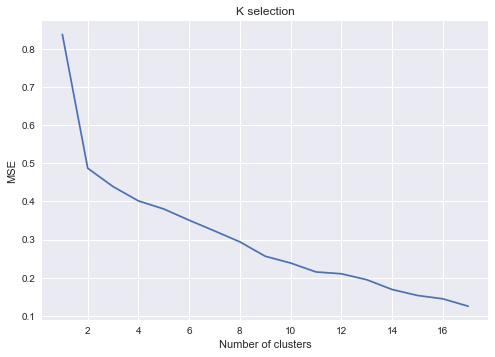

In [15]:
plt.style.use("seaborn")
Ks = 18
mse = np.zeros((Ks-1))
sfo_grouped_clustering = sfo_grouped.drop(['Neighborhood'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(sfo_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()


In [16]:
#clustering neighborhood into 5 clusters based on the elbow method!!
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sfo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 3, 4, 2, 2, 4, 4, 2, 4, 4])

In [19]:
#adding labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sfo_merged = rental_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sfo_merged = sfo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='where')

sfo_merged.head() # check the last columns!

,id,name,url,price,where,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,7032990766,"Prime Location, Amenities, Pet Friendly, Wooft...",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$4190,SOMA / south beach,37.786588,-122.401596,4.0,Coffee Shop,Gym,Café,Art Gallery,Gym / Fitness Center,Sandwich Place,Food Truck,Spa,Cocktail Bar,Lounge
1,7047709792,"1 BR in 3BR, 2 BA Apartment",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$1850,lower pac hts,37.785600,-122.435800,4.0,Cosmetics Shop,Yoga Studio,Spa,Café,Gym / Fitness Center,Sushi Restaurant,Sandwich Place,Tea Room,Gift Shop,Chinese Restaurant
2,7040514449,Remodeled 1 Bedroom 1 Bath- Furnished- laundr...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$1800,portola district,37.719000,-122.409600,1.0,Park,Garden,Recreation Center,Chinese Restaurant,Grocery Store,Mexican Restaurant,Liquor Store,Trail,Dog Run,Soccer Field
3,7047709931,Spectacular Panoramic City Skyline&Bay views ...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$5395,castro / upper market,37.757340,-122.445891,4.0,Trail,Gay Bar,Coffee Shop,Park,Grocery Store,Scenic Lookout,Sushi Restaurant,New American Restaurant,Gym,Thai Restaurant
4,7047709758,Spectacular Panoramic City Skyline&Bay views ...,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$4895,castro / upper market,37.757340,-122.445891,4.0,Trail,Gay Bar,Coffee Shop,Park,Grocery Store,Scenic Lookout,Sushi Restaurant,New American Restaurant,Gym,Thai Restaurant


In [21]:
sfo_merged.dropna(inplace=True)
sfo_merged['Cluster Labels'] = sfo_merged['Cluster Labels'].astype(int)

<H3>Plotting the cluster</H3>

In [22]:
#creating the map!!
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sfo_merged['Latitude'], sfo_merged['Longitude'], sfo_merged['where'], sfo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<H3> Analysing Clusters<H3>

In [23]:
#cluster 1
cl1 = sfo_merged.loc[sfo_merged['Cluster Labels'] == 0, sfo_merged.columns[[1] + list(range(5, sfo_merged.shape[1]))]]
cl1

,name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,2 bedroom top floor flat nr SFSU/CCSF,37.72185,-122.454378,0,Café,Coffee Shop,Bubble Tea Shop,Mexican Restaurant,Sandwich Place,Juice Bar,Liquor Store,Poke Place,Burger Joint,Vietnamese Restaurant
71,Fully renovated house with Ocean Views,37.72110,-122.475400,0,Café,Coffee Shop,Bubble Tea Shop,Mexican Restaurant,Sandwich Place,Juice Bar,Liquor Store,Poke Place,Burger Joint,Vietnamese Restaurant


In [24]:
#cluster 2
cl2 = sfo_merged.loc[sfo_merged['Cluster Labels'] == 1, sfo_merged.columns[[1] + list(range(5, sfo_merged.shape[1]))]]
cl2

,name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Remodeled 1 Bedroom 1 Bath- Furnished- laundr...,37.719000,-122.409600,1,Park,Garden,Recreation Center,Chinese Restaurant,Grocery Store,Mexican Restaurant,Liquor Store,Trail,Dog Run,Soccer Field
7,Remodeled 2BR 2BA flat with garage parking,37.776302,-122.484461,1,Café,Sushi Restaurant,Chinese Restaurant,Korean Restaurant,Grocery Store,Vietnamese Restaurant,Thai Restaurant,Dim Sum Restaurant,Bakery,Deli / Bodega
29,2BR/1BA with In-unit Washer/Dryer in Quiet Inn...,37.760741,-122.475886,1,Coffee Shop,Vietnamese Restaurant,Szechuan Restaurant,Bakery,Bubble Tea Shop,Deli / Bodega,Public Art,Dumpling Restaurant,Taco Place,Grocery Store
32,----$700 Private Room $500 deposit only--,37.744100,-122.486300,1,Chinese Restaurant,Dumpling Restaurant,Bubble Tea Shop,Korean Restaurant,Bar,Japanese Restaurant,Sandwich Place,Liquor Store,Café,Sushi Restaurant
34,Fully Furnished Studio Apartment near West Portal,37.745607,-122.472410,1,Chinese Restaurant,Martial Arts Dojo,Flower Shop,Trail,Sushi Restaurant,Szechuan Restaurant,Grocery Store,Optical Shop,Gas Station,Bus Stop
55,Small Private Suite - no kitchen -$900,37.729011,-122.419453,1,Park,Garden,Recreation Center,Chinese Restaurant,Grocery Store,Mexican Restaurant,Liquor Store,Trail,Dog Run,Soccer Field
59,335 24th ave-one bedroom apt. with parking,37.783288,-122.483890,1,Café,Sushi Restaurant,Chinese Restaurant,Korean Restaurant,Grocery Store,Vietnamese Restaurant,Thai Restaurant,Dim Sum Restaurant,Bakery,Deli / Bodega
63,"Beautiful home w/ 2 bed, 1 bath & 2 parking space",37.719000,-122.409600,1,Park,Garden,Recreation Center,Chinese Restaurant,Grocery Store,Mexican Restaurant,Liquor Store,Trail,Dog Run,Soccer Field
82,Cozy 1 Bedroom Unit - With Extra Bed/Office Room,37.744100,-122.486300,1,Chinese Restaurant,Dumpling Restaurant,Bubble Tea Shop,Korean Restaurant,Bar,Japanese Restaurant,Sandwich Place,Liquor Store,Café,Sushi Restaurant
87,Silver Terrace 3 Bedroom 1 Bath Unit for Rent,37.731956,-122.399673,1,Park,Garden,Recreation Center,Chinese Restaurant,Grocery Store,Mexican Restaurant,Liquor Store,Trail,Dog Run,Soccer Field


In [25]:
#cluster 3
cl3 = sfo_merged.loc[sfo_merged['Cluster Labels'] == 2, sfo_merged.columns[[1] + list(range(5, sfo_merged.shape[1]))]]
cl3

,name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,2 blocks away form USF! Lovely 2BR flat ! conv...,37.772995,-122.445902,2,Boutique,Coffee Shop,Café,Clothing Store,Thrift / Vintage Store,Bar,Deli / Bodega,Pizza Place,Gastropub,Supermarket
30,"Charming corner apt on lovely Potrero Hill, Pe...",37.762100,-122.397100,2,Café,Park,Coffee Shop,Gym / Fitness Center,Breakfast Spot,Liquor Store,Mexican Restaurant,Office,Playground,Cosmetics Shop
31,Beautiful Victorian full 4 bedroom flat,37.767238,-122.449300,2,Boutique,Coffee Shop,Breakfast Spot,Clothing Store,Park,Thrift / Vintage Store,Ice Cream Shop,Wine Bar,Gift Shop,Shoe Store
33,"Co-Working Lab & Coding Room, HIIT Fitness Cen...",37.758028,-122.395081,2,Café,Park,Coffee Shop,Gym / Fitness Center,Breakfast Spot,Liquor Store,Mexican Restaurant,Office,Playground,Cosmetics Shop
56,huge 1br private ent 10 minutes to fin dist,37.779439,-122.440397,2,Bar,Boutique,Café,Coffee Shop,Clothing Store,Sushi Restaurant,Thrift / Vintage Store,Pizza Place,Yoga Studio,Marijuana Dispensary
57,huge 1br private ent 10 minutes to fin dist,37.779439,-122.440397,2,Bar,Boutique,Café,Coffee Shop,Clothing Store,Sushi Restaurant,Thrift / Vintage Store,Pizza Place,Yoga Studio,Marijuana Dispensary
58,1br flat 10 min to financial dist great quiet ...,37.779439,-122.440397,2,Boutique,Coffee Shop,Café,Clothing Store,Thrift / Vintage Store,Bar,Deli / Bodega,Pizza Place,Gastropub,Supermarket
69,"$2450 1 bedroom, 1 Bath",37.752018,-122.401364,2,Café,Park,Coffee Shop,Gym / Fitness Center,Breakfast Spot,Liquor Store,Mexican Restaurant,Office,Playground,Cosmetics Shop
74,Charming 2 Bedroom apartment - NOPA,37.778330,-122.441630,2,Bar,Sushi Restaurant,Café,Mexican Restaurant,Liquor Store,Pizza Place,Marijuana Dispensary,Boutique,Gift Shop,Mediterranean Restaurant
90,2 blocks away form USF! Lovely 3BR flat ! conv...,37.772995,-122.445902,2,Boutique,Coffee Shop,Café,Clothing Store,Thrift / Vintage Store,Bar,Deli / Bodega,Pizza Place,Gastropub,Supermarket


In [26]:
#cluster 4
cl4 = sfo_merged.loc[sfo_merged['Cluster Labels'] == 3, sfo_merged.columns[[1] + list(range(5, sfo_merged.shape[1]))]]
cl4

,name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
73,"Retire to the Valley 55 & older quiet, close in.",37.663626,-120.989124,3,Chinese Restaurant,Automotive Shop,Fast Food Restaurant,Fabric Shop,Farm,Farmers Market,Field,Filipino Restaurant,Fish Market,Flea Market
76,"Retire to the Valley 55 & older quiet, close in.",37.663626,-120.989124,3,Chinese Restaurant,Automotive Shop,Fast Food Restaurant,Fabric Shop,Farm,Farmers Market,Field,Filipino Restaurant,Fish Market,Flea Market


In [27]:
#cluster 5
cl5 = sfo_merged.loc[sfo_merged['Cluster Labels'] == 4, sfo_merged.columns[[1] + list(range(5, sfo_merged.shape[1]))]]
cl5

,name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Prime Location, Amenities, Pet Friendly, Wooft...",37.786588,-122.401596,4,Coffee Shop,Gym,Café,Art Gallery,Gym / Fitness Center,Sandwich Place,Food Truck,Spa,Cocktail Bar,Lounge
1,"1 BR in 3BR, 2 BA Apartment",37.785600,-122.435800,4,Cosmetics Shop,Yoga Studio,Spa,Café,Gym / Fitness Center,Sushi Restaurant,Sandwich Place,Tea Room,Gift Shop,Chinese Restaurant
3,Spectacular Panoramic City Skyline&Bay views ...,37.757340,-122.445891,4,Trail,Gay Bar,Coffee Shop,Park,Grocery Store,Scenic Lookout,Sushi Restaurant,New American Restaurant,Gym,Thai Restaurant
4,Spectacular Panoramic City Skyline&Bay views ...,37.757340,-122.445891,4,Trail,Gay Bar,Coffee Shop,Park,Grocery Store,Scenic Lookout,Sushi Restaurant,New American Restaurant,Gym,Thai Restaurant
5,2 mintues walk to Google shuttle! Spacious 4BR...,37.742295,-122.423286,4,Coffee Shop,Pizza Place,Mexican Restaurant,Italian Restaurant,Breakfast Spot,Art Gallery,Thai Restaurant,Gay Bar,Chinese Restaurant,Convenience Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Beautiful HUGE Two Bedroom Apartment close to ...,37.792507,-122.420076,4,Bar,Coffee Shop,Gym / Fitness Center,Gym,Italian Restaurant,Sushi Restaurant,Grocery Store,Vietnamese Restaurant,Steakhouse,Spa
95,Beautiful HUGE Two Bedroom Apartment close to ...,37.792507,-122.420076,4,Bar,Coffee Shop,Gym / Fitness Center,Gym,Italian Restaurant,Sushi Restaurant,Grocery Store,Vietnamese Restaurant,Steakhouse,Spa
96,Exceptional 2 Bedroom Apartment in Russian Hill,37.792507,-122.420076,4,Bar,Coffee Shop,Gym / Fitness Center,Gym,Italian Restaurant,Sushi Restaurant,Grocery Store,Vietnamese Restaurant,Steakhouse,Spa
97,DELUXE 1 STUDIO PREWAR APARTMENT NEAR LAFAYETT...,37.791064,-122.424295,4,Cosmetics Shop,Bar,Gym,Gym / Fitness Center,Park,Steakhouse,Pet Store,Italian Restaurant,Coffee Shop,Sushi Restaurant


<H3>Data visualization<H3>

In [28]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[2,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = sfo_grouped_clustering.columns[args.astype(int)])
table = table.transpose()


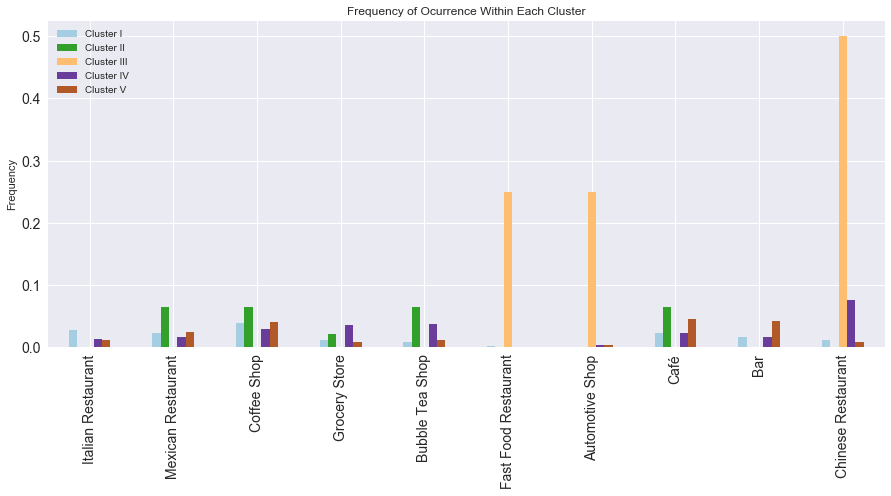

In [29]:

plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()


<H3>Conclusion</H3>
    We could see that the rental place are clustered into 5 clusters based on the venus near by the rental place.
    
   <B>Cluster I</B>  - More Coffee Shop, few Italian Restaurant, Mexican Restaurant and Bar, very few Grocery Store, Chinese Restaurant.<br/> 
   <B>Cluster II</B> - More Mexican Restaurant, Coffee Shop, Bubble Tea Shop and Cafe, very few Grocery Store.<br/> 
   <B>Cluster III</B>- More Chinese Restaurant, Fast Food Restaurant and Automotive Shop.<br/> 
   <B>Cluster IV</B> - More Chinese Restaurant, few Bubble Tea Shop, Grocery Store and Coffee Shope, very few Bar, Italian Restaurant and Mexican Restaurent.<br/> 
   <B>Cluster V</B>  - More Coffee Shop, Cafe and Bar, very few Italian Restaurant, Mexican Restaurant and Chinese Restaurant.